In [1]:
import pandas as pd 
import os   
import matplotlib.pyplot as plt
import matplotlib 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%time
# ABRIMOS EL ARCHIVO
data_oscars = pd.read_csv(os.path.join("oscar_award.csv","the_oscar_award.csv"))
data_oscars

Wall time: 15 ms


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10390,2019,2020,92,WRITING (Original Screenplay),"Screenplay by Bong Joon Ho, Han Jin Won; Story...",Parasite,True
10391,2019,2020,92,JEAN HERSHOLT HUMANITARIAN AWARD,Geena Davis,NaN,True
10392,2019,2020,92,HONORARY AWARD,David Lynch,NaN,True
10393,2019,2020,92,HONORARY AWARD,Wes Studi,NaN,True


In [3]:
%%time
# ABRIMOS EL ARCHIVO
data_oscars = pd.read_csv(os.path.join("oscar_award.csv","the_oscar_award.csv"))
# ELIMINAMOS DATOS NULOS
data_oscars = data_oscars.dropna()

# MODIFICAMOS MOMENTANEAMENTE EL NOMBRE PARA PODER GENERAR DATAFRAME
for ind in data_oscars.index:
    film,year = data_oscars['film'][ind],data_oscars['year_film'][ind]
    data_oscars['film'][ind]=f'{film}[{year}]'

# GENERAMOS UNA LISTA CON CADA PELICULA DISTINTA, DIFERENCIADAS POR SU TITULO Y AÑO PARA NO AGRUPAR REMASTERIZACIONES
movies = []
nominaciones = []
wins = []
for movie in data_oscars['film']:
    if movie not in movies:
        movies.append(movie)

for movie in movies:
    nomin = len(data_oscars[data_oscars['film']==movie])
    nominaciones.append(nomin)
    ganadas = len(data_oscars[(data_oscars['film']==movie)&(data_oscars['winner']==True)])
    wins.append(ganadas)

# GENERAMOS DATAFRAME
diccionario_df = {'Pelicula': movies, 'Nominaciones': nominaciones, 'Premios': wins} 

df = pd.DataFrame(diccionario_df)
#ese es de las nominaciones
df

<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 8.32 s


,Pelicula,Nominaciones,Premios
0,The Noose[1927],1,0
1,The Last Command[1927],2,1
2,A Ship Comes In[1927],1,0
3,7th Heaven[1927],5,3
4,Sadie Thompson[1927],1,0
...,...,...,...
4929,A Sister[2019],1,0
4930,Ad Astra[2019],1,0
4931,Avengers: Endgame[2019],1,0
4932,The Lion King[2019],1,0


In [4]:
%%time
data_ratings = pd.read_csv(os.path.join("ratings_small.csv","ratings_small.csv"))

movies_id = []
ratings = []
cant_ratings = []
for Id in data_ratings['movieId'].unique():
    movies_id.append(Id)
    ratings.append(round(data_ratings[data_ratings['movieId']==Id]['rating'].mean(),1))
    cant_ratings.append(len(data_ratings[data_ratings['movieId']==Id]))

diccionario_ratings = {'IdPelicula': movies_id, 'RatingProm': ratings, 'Cant_Ratings': cant_ratings} 

df_ratings = pd.DataFrame(diccionario_ratings)
df_ratings

Wall time: 4.98 s


,IdPelicula,RatingProm,Cant_Ratings
0,31,3.2,42
1,1029,3.7,42
2,1061,3.5,33
3,1129,3.3,48
4,1172,4.3,46
...,...,...,...
9061,64997,2.5,1
9062,72380,3.5,1
9063,129,3.0,1
9064,4736,1.0,1


In [5]:
data_movies = pd.read_csv(os.path.join("movies_metadata.csv","movies_metadata.csv"))
columns = ['title', 'original_title', 'genres', 'id', 'imdb_id', 'original_language', 'popularity', 'release_date', 'production_countries']
data_movies = data_movies[columns]
#Eliminamos los datos Nulos 
data_movies = data_movies.dropna()
data_movies = data_movies.drop(data_movies[data_movies['genres']== '[]'].index)
data_movies['id'] = data_movies['id'].astype('int64')
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42971 entries, 0 to 45463
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title                 42971 non-null  object
 1   original_title        42971 non-null  object
 2   genres                42971 non-null  object
 3   id                    42971 non-null  int64 
 4   imdb_id               42971 non-null  object
 5   original_language     42971 non-null  object
 6   popularity            42971 non-null  object
 7   release_date          42971 non-null  object
 8   production_countries  42971 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.3+ MB


C:\Users\chile\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# Merge entre las peliculas y sus ratings
movie_ratings = pd.merge(data_movies, df_ratings, left_on = 'id', right_on = 'IdPelicula', how = 'left')
movie_ratings = movie_ratings.dropna().reset_index(drop=True)
movie_ratings
movie_ratings.release_date = pd.to_datetime(movie_ratings['release_date'])
movie_ratings["year"] = movie_ratings.release_date.dt.year
movie_ratings.sort_values('year')

,title,original_title,genres,id,imdb_id,original_language,popularity,release_date,production_countries,IdPelicula,RatingProm,Cant_Ratings,year
2244,The Arrival of a Train at La Ciotat,L'arrivée d'un train en gare de La Ciotat,"[{'id': 99, 'name': 'Documentary'}]",160,tt0000012,es,5.256608,1896-01-25,"[{'iso_3166_1': 'FR', 'name': 'France'}]",160.0,2.3,63.0,1896
2800,The One-Man Band,L'Homme orchestre,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",49280,tt0135453,fr,1.109068,1900-01-01,"[{'iso_3166_1': 'FR', 'name': 'France'}]",49280.0,5.0,1.0,1900
1508,A Trip to the Moon,Le Voyage dans la Lune,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",775,tt0000417,fr,6.321801,1902-09-01,"[{'iso_3166_1': 'FR', 'name': 'France'}]",775.0,2.0,1.0,1902
2787,Extraordinary Illusions,Illusions funambulesques,"[{'id': 35, 'name': 'Comedy'}]",127098,tt0223509,fr,0.141611,1903-01-01,"[{'iso_3166_1': 'FR', 'name': 'France'}]",127098.0,4.0,1.0,1903
2202,Frankenstein,Frankenstein,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",2929,tt0001223,en,1.659883,1910-03-18,"[{'iso_3166_1': 'US', 'name': 'United States o...",2929.0,3.9,14.0,1910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048,Dante's Hell Animated,Dante's Hell Animated,"[{'id': 16, 'name': 'Animation'}]",31156,tt1472122,en,0.787493,2013-11-25,"[{'iso_3166_1': 'US', 'name': 'United States o...",31156.0,3.0,1.0,2013
2557,Heart of the Country,Heart of the Country,"[{'id': 10751, 'name': 'Family'}, {'id': 10749...",97938,tt2231251,en,1.0927,2013-08-19,"[{'iso_3166_1': 'US', 'name': 'United States o...",97938.0,3.8,22.0,2013
2302,The Cosmonaut,The Cosmonaut,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",86817,tt1629747,en,0.643925,2013-05-17,"[{'iso_3166_1': 'ES', 'name': 'Spain'}, {'iso_...",86817.0,5.0,1.0,2013
2340,Sin City: A Dame to Kill For,Sin City: A Dame to Kill For,"[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name...",189,tt0458481,en,20.623642,2014-08-20,"[{'iso_3166_1': 'US', 'name': 'United States o...",189.0,4.0,1.0,2014


In [7]:
data_ratings_externo = pd.read_csv(os.path.join("ratings_externo","IMDb ratings.csv"))
columnas = ['imdb_title_id', 'weighted_average_vote', 'total_votes', 'mean_vote']
data_ratings_externo = data_ratings_externo[columnas]
data_ratings_externo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   weighted_average_vote  85855 non-null  float64
 2   total_votes            85855 non-null  int64  
 3   mean_vote              85855 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.6+ MB


In [8]:
movie_ratings_2 = pd.merge(data_movies, data_ratings_externo, left_on = 'imdb_id', right_on = 'imdb_title_id', how = 'left')
movie_ratings_2 = movie_ratings_2.dropna().reset_index(drop=True)
movie_ratings_2
movie_ratings_2.release_date = pd.to_datetime(movie_ratings_2['release_date'])
movie_ratings_2["year"] = movie_ratings_2.release_date.dt.year
# hacemos una limpieza de los anos, ya que sera comparado con los oscars y estos toman las peliculas desde el ano 1927 
movie_ratings_2 = movie_ratings_2.drop(movie_ratings_2[movie_ratings_2['year'] < 1927].index)

In [9]:
genres = movie_ratings_2['genres']
genre_movie = []
generos_totales = []
for i in genres:
    genre = ''
    generos_pelicula = i.split("'")[5::6]
    for j in generos_pelicula:
        if j not in generos_totales:
            generos_totales.append(j)
    for x in range(len(generos_pelicula)):
        if x < len(generos_pelicula) -1:
            genre+=f'{generos_pelicula[x]},'
        else:
            genre+=generos_pelicula[x]
    genre_movie.append(genre)
movie_ratings_2['genres'] = genre_movie

In [10]:
df_genre = pd.DataFrame()
for genre in generos_totales:
    df_genre[genre] = movie_ratings_2['genres'].str.contains(genre).map(lambda x:1 if x else 0)
# a este data frame le agregaremos el ano para poder hacer una comparacion de cuantas peliculas por ano se filman para cada genero 
df_genre['year'] = movie_ratings_2["year"]
# hacemos groupby segun el ano para ver las cta de peliculas
genero_peliculas_ano = df_genre.groupby('year').sum()
# hacemos sort para ver el grafico en orden
genero_peliculas_ano_sumados = genero_peliculas_ano.sum().sort_values(ascending=False)

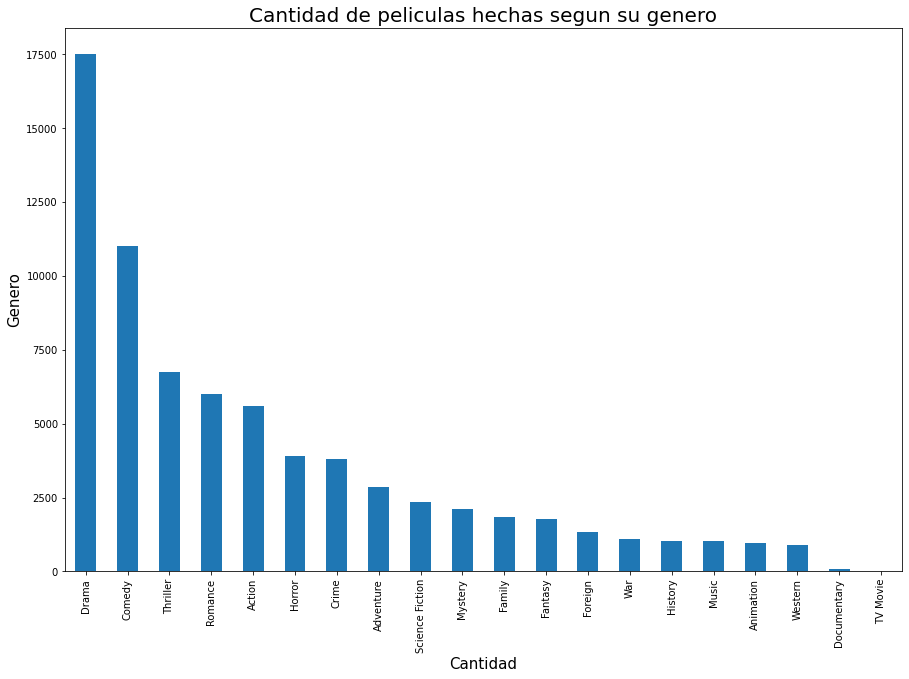

In [11]:
#grafico de cuantas peliculas se generan 
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(1,1,1)
# un grafico de barras para que sea mas descriptivo y facil de analizar
ax = genero_peliculas_ano_sumados.plot.bar()
plt.xticks(rotation=90)
plt.title('Cantidad de peliculas hechas segun su genero', fontsize = 20)
plt.ylabel('Genero', fontsize = 15)
plt.xlabel('Cantidad', fontsize = 15)
plt.show()

In [12]:
df_genre = pd.DataFrame()
for genre in generos_totales:
    df_genre[genre] = movie_ratings_2['genres'].str.contains(genre).map(lambda x:1 if x else 0)
movie_ratings_2 = movie_ratings_2.join(df_genre)
movie_ratings_2

,title,original_title,genres,id,imdb_id,original_language,popularity,release_date,production_countries,imdb_title_id,...,Horror,History,Science Fiction,Mystery,War,Music,Foreign,Western,Documentary,TV Movie
0,Toy Story,Toy Story,"Animation,Comedy,Family",862,tt0114709,en,21.946943,1995-10-30,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji,Jumanji,"Adventure,Fantasy,Family",8844,tt0113497,en,17.015539,1995-12-15,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,Grumpier Old Men,"Romance,Comedy",15602,tt0113228,en,11.7129,1995-12-22,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113228,...,0,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale,Waiting to Exhale,"Comedy,Drama,Romance",31357,tt0114885,en,3.859495,1995-12-22,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114885,...,0,0,0,0,0,0,0,0,0,0
4,Father of the Bride Part II,Father of the Bride Part II,Comedy,11862,tt0113041,en,8.387519,1995-02-10,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113041,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32902,House of Horrors,House of Horrors,"Horror,Mystery,Thriller",84419,tt0038621,en,0.222814,1946-03-29,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0038621,...,1,0,0,1,0,0,0,0,0,0
32903,Caged Heat 3000,Caged Heat 3000,Science Fiction,222848,tt0112613,en,0.661558,1995-01-01,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0112613,...,0,0,1,0,0,0,0,0,0,0
32904,Robin Hood,Robin Hood,"Drama,Action,Romance",30840,tt0102797,en,5.683753,1991-05-13,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",tt0102797,...,0,0,0,0,0,0,0,0,0,0
32905,Century of Birthing,Siglo ng Pagluluwal,Drama,111109,tt2028550,tl,0.178241,2011-11-17,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",tt2028550,...,0,0,0,0,0,0,0,0,0,0


In [13]:
import ast
import geopandas as gpd

In [14]:
%%time
paises = []
for ind in movie_ratings_2['production_countries'].index:
    x = ast.literal_eval(movie_ratings_2['production_countries'][ind])
    if len(x) > 0:
        countries = []
        countries_str = ''
        for dat in x:
            pais = dat['name']
            countries.append(dat['name'])
            countries_str += f'{pais},'
            if dat['name'] not in paises:
                paises.append(dat['name'])
    #movie_ratings_2['production_countries'][ind] = countries
    movie_ratings_2['production_countries'][ind] = countries_str


<timed exec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 7.94 s


In [16]:
df_countries = pd.DataFrame()
for pais in paises:
    df_countries[pais] = movie_ratings_2['production_countries'].str.contains(pais).map(lambda x:1 if x else 0)
df_countries

C:\Users\chile\AppData\Local\Temp/ipykernel_5460/915704723.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_countries[pais] = movie_ratings_2['production_countries'].str.contains(pais).map(lambda x:1 if x else 0)


,United States of America,Germany,United Kingdom,France,Italy,Spain,China,Australia,South Africa,Canada,...,Nigeria,Lao People's Democratic Republic,Guatemala,Kyrgyz Republic,Papua New Guinea,Uganda,French Southern Territories,Samoa,Gibraltar,Brunei Darussalam
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32902,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32903,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32904,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
32905,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# a este data frame le agregaremos el ano para poder hacer una comparacion de cuantas peliculas se filman en un pais
df_countries['year'] = movie_ratings_2["year"]
# hacemos groupby segun el ano para ver las cta de peliculas por pais
peliculas_pais_ano = df_countries.groupby('year').sum()
# hacemos sort para ver el grafico en orden
peliculas_pais_ano_sumados = peliculas_pais_ano.sum().sort_values(ascending=False)

C:\Users\chile\AppData\Local\Temp/ipykernel_5460/359411363.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_countries['year'] = movie_ratings_2["year"]


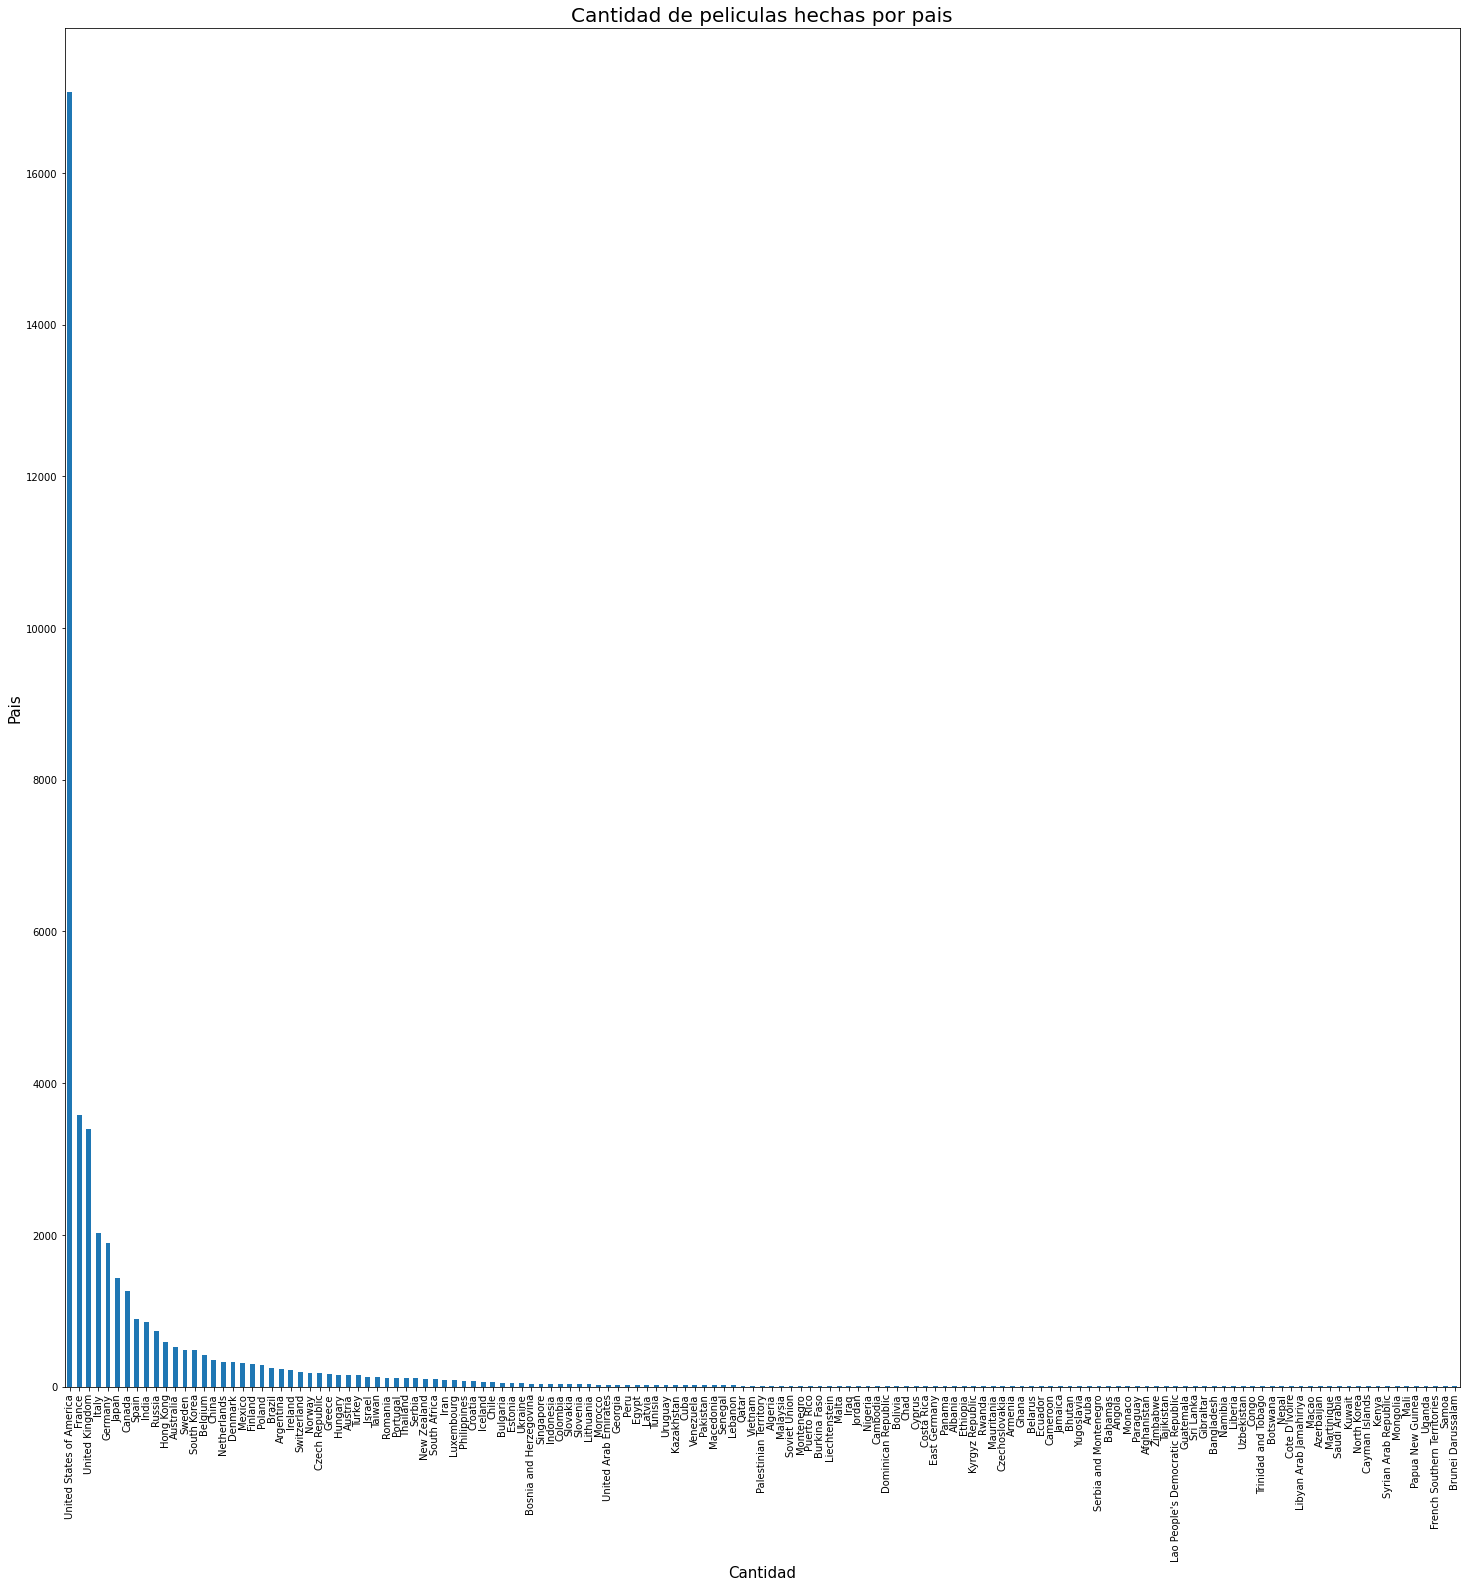

In [19]:
#grafico de cuantas peliculas en un pais se generan
fig = plt.figure(figsize=(25,25))
ax = plt.subplot(1,1,1)
# un grafico de barras para que sea mas descriptivo y facil de analizar
ax = peliculas_pais_ano_sumados.plot.bar()
plt.xticks(rotation=90)
plt.title('Cantidad de peliculas hechas por pais', fontsize = 20)
plt.ylabel('Pais', fontsize = 15)
plt.xlabel('Cantidad', fontsize = 15)
plt.show()

In [ ]:
movie_ratings_2

In [ ]:
"""
Descargamos geodataset para relacionar país con calidad y recepción de producciones.
Sjoin debe ser por columna "sovereight"
"""
url = 'https://data.opendatasoft.com/explore/dataset/natural-earth-countries-1_110m@public/download/?format=geojson&timezone=America/Santo_Domingo&lang=en'
gdf_paises = gpd.read_file(url)
gdf_paises